In [59]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env', verbose=True)

True

In [60]:
import os

BIGQUERY_PROJECT_ID = os.environ.get('BIGQUERY_PROJECT_ID')
BIGQUERY_DATASET = os.environ.get('BIGQUERY_DATASET')
BIGQUERY_DATASET_REGION = os.environ.get('BIGQUERY_DATASET_REGION')
BIGQUERY_TABLE = os.environ.get('BIGQUERY_TABLE')

VERTEXAI_PROJECT_ID = os.environ.get('VERTEXAI_PROJECT_ID')
VERTEXAI_REGION = os.environ.get('VERTEXAI_REGION')

BUCKET_NAME = os.environ.get('BUCKET_NAME')
BUCKET_URI = os.environ.get('BUCKET_URI')
BUCKET_REGION = os.environ.get('BUCKET_REGION')

PREFIX = os.environ.get('PREFIX')

print("BIGQUERY_PROJECT_ID: ",BIGQUERY_PROJECT_ID)
print("BIGQUERY_DATASET: ",BIGQUERY_DATASET)
print("BIGQUERY_DATASET_REGION: ",BIGQUERY_DATASET_REGION)
print("BIGQUERY_TABLE: ",BIGQUERY_TABLE)

print("VERTEXAI_PROJECT_ID: ",VERTEXAI_PROJECT_ID)
print("VERTEXAI_REGION: ",VERTEXAI_REGION)

print("BUCKET_NAME: ",BUCKET_NAME)
print("BUCKET_URI: ",BUCKET_NAME)
print("BUCKET_REGION: ",VERTEXAI_REGION)


PIPELINE_ROOT = 'gs://{}/pipeline_root'.format(BUCKET_NAME)

BIGQUERY_PROJECT_ID:  datafusionsbox
BIGQUERY_DATASET:  dataset4ccc
BIGQUERY_DATASET_REGION:  us
BIGQUERY_TABLE:  df_for_model_ccc_with_weights
VERTEXAI_PROJECT_ID:  datafusionsbox
VERTEXAI_REGION:  us-central1
BUCKET_NAME:  gcp-demo-ccc-vertexai
BUCKET_URI:  gcp-demo-ccc-vertexai
BUCKET_REGION:  us-central1


In [61]:
from google.cloud import aiplatform

aiplatform.init(
    project=VERTEXAI_PROJECT_ID,
    location=VERTEXAI_REGION
)

In [62]:
model_filter_str='labels.experiment_name="'+f"{PREFIX}-experiments"+'"'

models = aiplatform.Model.list(
        filter=model_filter_str
)
    
model = models[0]

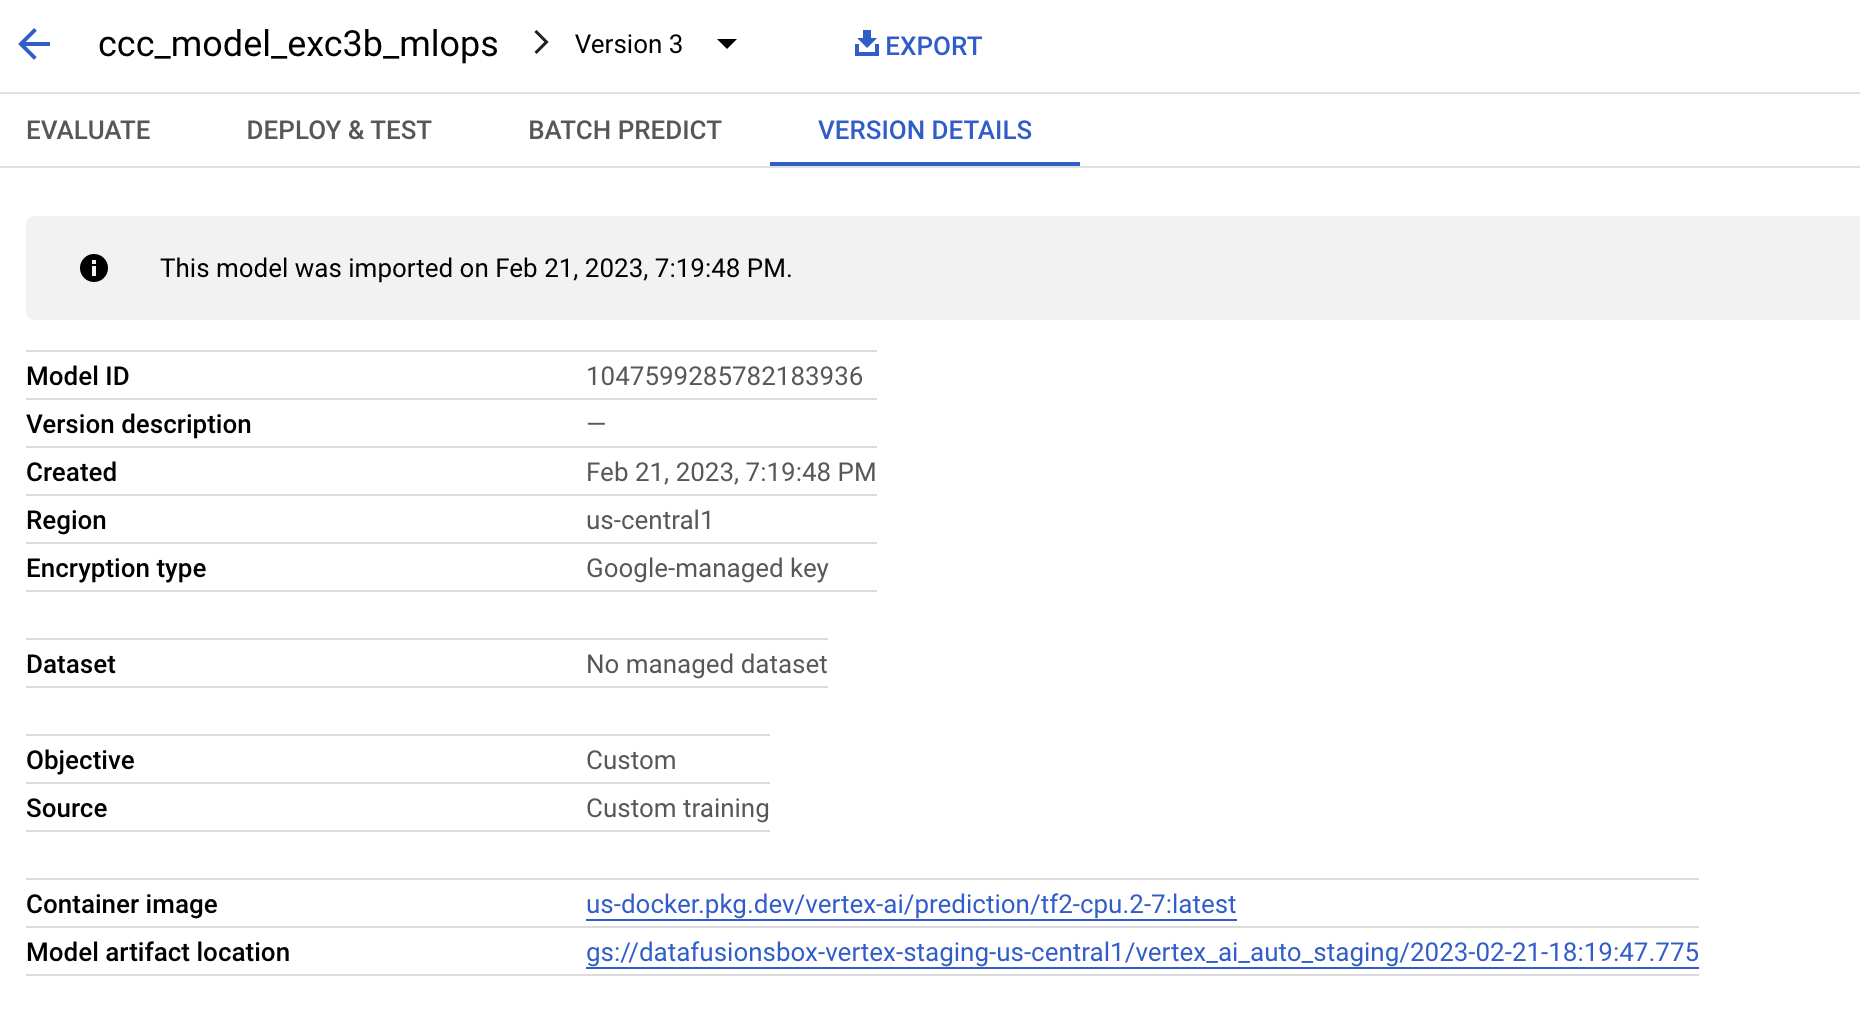

https://cloud.google.com/python/docs/reference/aiplatform/1.18.2/google.cloud.aiplatform.Model

In [63]:
model.name, model.uri

('1047599285782183936',
 'gs://datafusionsbox-vertex-staging-us-central1/vertex_ai_auto_staging/2023-02-21-18:19:47.775')

### Import model to BigQuery

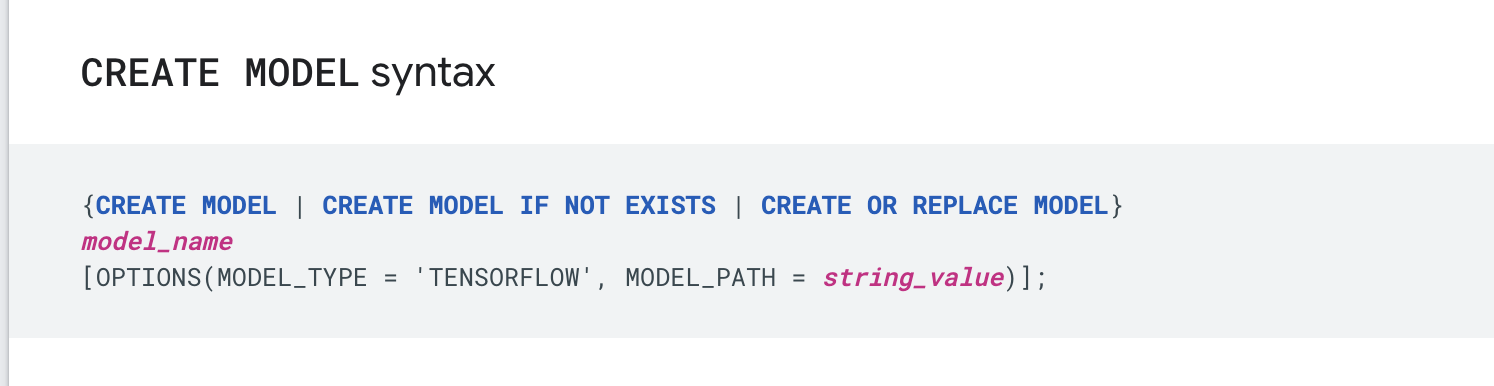

In [7]:
create_model_query = f"""
   CREATE OR REPLACE MODEL {BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{PREFIX}_imported_model 
   OPTIONS (MODEL_TYPE='TENSORFLOW',
   MODEL_PATH='{model.uri}/*')
   """
create_model_query

"\n   CREATE OR REPLACE MODEL datafusionsbox.dataset4ccc.ccc_imported_model \n   OPTIONS (MODEL_TYPE='TENSORFLOW',\n   MODEL_PATH='gs://datafusionsbox-vertex-staging-us-central1/vertex_ai_auto_staging/2023-02-21-18:19:47.775/*')\n   "

In [67]:
from google.cloud import bigquery
client = bigquery.Client()

result = client.query(create_model_query)

### Visit BigQuery

In [68]:
from google.cloud import bigquery

table_id = f"{BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}"

client = bigquery.Client()
table = client.get_table(table_id)  # Make an API request.

print(
    "Got table '{}.{}.{}'.".format(table.project, table.dataset_id, table.table_id)
)

Got table 'datafusionsbox.dataset4ccc.df_for_model_ccc_with_weights'.


In [69]:
_excluded_columns = ["synerise_client_id", "weight", "y_if_trans"]

In [70]:
_features = []
for schema_field in table.schema:
    if schema_field.name not in _excluded_columns:
       _features.append(schema_field.name)

### Run Prediction job

In [77]:
prediction_query = f"""
SELECT * 
   FROM
   ML.PREDICT(
   MODEL {BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{PREFIX}_imported_model,
   (SELECT [{','.join(_features)}] AS dense_3_input FROM (
      SELECT * except ({','.join(_excluded_columns)}) 
      FROM {BIGQUERY_PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TABLE}
     ) 
    )
    )
 """
prediction_query

'\nSELECT * \n   FROM\n   ML.PREDICT(\n   MODEL datafusionsbox.dataset4ccc.ccc_imported_model,\n   (SELECT [www_visits_month_freq_1,www_visits_month_freq_2,www_visits_month_freq_3,www_pages_visited_month_1,www_pages_visited_month_2,www_pages_visited_month_3,www_time_onsite_avg_month_1,www_time_onsite_avg_month_2,www_time_onsite_avg_month_3,www_trans_month_freq_1,www_trans_month_freq_2,www_trans_month_freq_3,www_basket_value_monthly_1,www_basket_value_monthly_2,www_basket_value_monthly_3,www_coupon_add_month_1,www_coupon_add_month_2,www_coupon_add_month_3,www_device_freq_mobile,www_device_freq_desktop,www_umbrella_click_month_1,www_umbrella_click_month_2,www_umbrella_click_month_3,www_promo_click_month_1,www_promo_click_month_2,www_promo_click_month_3,www_gallery_click_month_1,www_gallery_click_month_2,www_gallery_click_month_3,www_channel_freq__direct_organic,www_channel_freq__sem,www_channel_freq__facebook,www_channel_freq__portale,www_channel_freq__klub,www_channel_freq__afiliacja,ww

In [ ]:
##STRUCT(0.55 AS threshold)

In [79]:
from google.cloud import bigquery
client = bigquery.Client()

dataframe = client.query(prediction_query).to_dataframe()

In [80]:
dataframe.head()

,dense_5,dense_3_input
0,0.009930,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.071777,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.127519,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.169365,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.105554,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


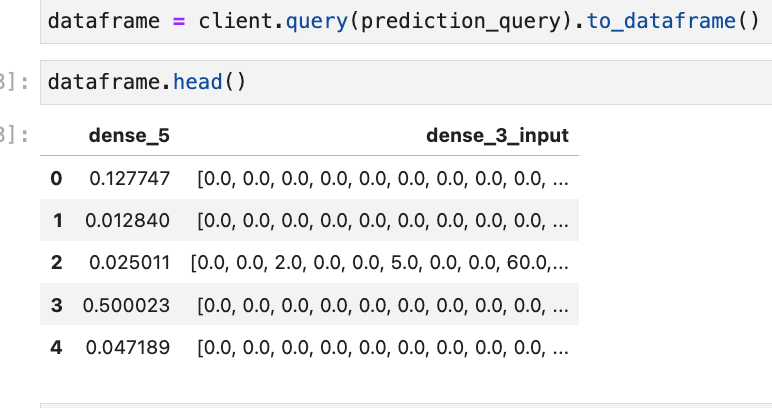